# CS794 Question 5

### Imports

In [ ]:
from PIL import Image
import numpy as np
from numpy.linalg import lstsq, norm
import os
import matplotlib.pyplot as plt

### Prepare the Data

In [ ]:
!wget http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz
!tar -xzf JPEGS.tar.gz
%cd JPEGS
%cd birds

--2023-11-30 20:46:31--  http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67365612 (64M) [application/x-gzip]
Saving to: ‘JPEGS.tar.gz’

JPEGS.tar.gz        100%[===================>]  64.24M  19.5MB/s    in 5.2s    

2023-11-30 20:46:36 (12.5 MB/s) - ‘JPEGS.tar.gz’ saved [67365612/67365612]

/content/JPEGS
/content/JPEGS/birds


In [ ]:
def form_Ay():
    # Get the current directory
    path = os.getcwd()
    # print(path)

    # Get a list of image file names in the directory
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
    sort_image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Initialize the matrix
    mtx = np.zeros((37752, len(sort_image_files)))

    # Iterate through each image file
    for i, image_file in enumerate(sort_image_files):
        # Load the image using Pillow
        img = Image.open(os.path.join(path, image_file))
        # print(np.array(img).shape) (156, 242)

        # Convert the image to grayscale
        img_gray = img.convert('L')

        # Flatten the image matrix to a 1D array and insert into matrix A
        mtx[:, i] = np.array(img_gray).flatten()

    A = mtx[:, :70]
    y = mtx[:, -1]

    return mtx, A, y

### AMRR (Alternating Minimization for Robust Regression)

In [ ]:
def amrr(A, y, ell, tol):
    # Initilization
    m, n = A.shape
    S = set(range(m - ell))
    x = np.zeros((n, 1))
    consecutive_iter = 0
    numit = 0

    while consecutive_iter < 10:
        numit += 1
        # Linear Least Square
        x_prev = x.copy()
        A_sk = A[list(S), :]
        y_sk = y[list(S)]
        x = lstsq(A_sk, y_sk, rcond=None)[0]

        # print(x)
        # print(x.shape)

        # Residuals and sorting
        r = A @ x - y
        sorted_indices = np.argsort(np.abs(r), axis=0)
        S = list(sorted_indices[: m - ell])
        # print(f"S: {S}")

        # Termination
        if norm(x - x_prev) <= tol:
            consecutive_iter += 1
        else:
            consecutive_iter = 0

    # print(f"Number of Iteration: {numit}")
    # print(f"Regression coefficients (x): {x}")
    # print(f"List of m - ell entries over which the minimizer is taken (S): {S}")
    # print(f"Length of S: {len(S)}")
    return x, S

### Driver (Produce Two Plots)

In [ ]:
### Length of S: 36552 and total length: 37752
def plot_images(A, x, y, S):
    # m = len(y)
    # S_total = set(range(m))
    # S_complement = S_total - set(S)

    # Not covered by S (y_complement)
    y_complement = np.copy(y)
    y_complement[list(S)] = 255

    y_complement_image = y_complement.reshape((156, 242)).astype(np.uint8)

    y_fit = A[S, :] @ x

    y_fit_image = np.zeros(156 * 242, dtype=np.uint8)
    y_fit_image[list(S)] = y_fit.astype(np.uint8)
    # Set entries not indexed by S to white (255)
    y_fit_image[y_fit_image == 0] = 255

    # Reshape y_fit_image based on the dimensions of S
    y_fit_image = y_fit_image.reshape((156, 242))

    # Plot the images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(y_complement_image, cmap='gray')
    plt.title('Image not covered by S')

    plt.subplot(1, 2, 2)
    plt.imshow(y_fit_image, cmap='gray')
    plt.title('Fitted image indexed by S')

    plt.show()

In [ ]:
def driver():
    # Initilization
    ell = 1200
    tol = 1e-10
    # Prepare the data
    mtx, A, y = form_Ay()
    # Apply AMRR algorithm
    x, S = amrr(A, y, ell, tol)
    # Plot the images
    plot_images(A, x, y, S)

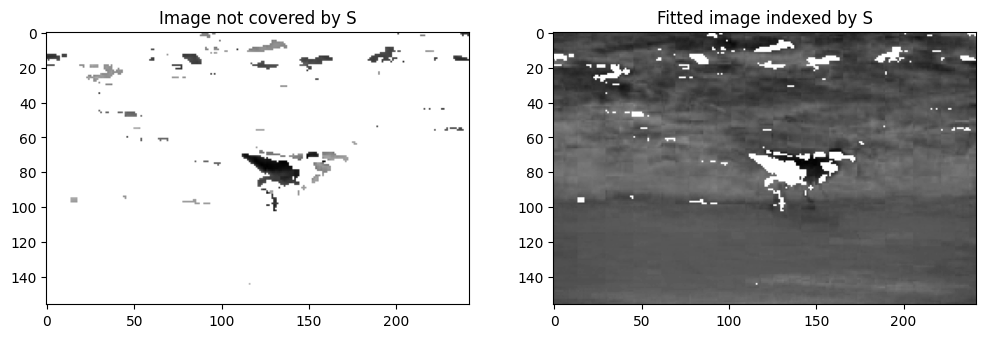

In [ ]:
driver()